In [1]:
#importing necssary libraries
import pathlib  
import numpy as np  
import matplotlib.pyplot as plt  
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers  
from tensorflow.keras.models import Sequential, save_model,load_model 
from sklearn.model_selection import train_test_split 
import librosa

In [2]:
#counting the total number of audio files
audio_count = sum(1 for _ in pathlib.Path(str(pathlib.Path.cwd())+'//audios_folder').rglob('*.wav'))
audio_count


2913

In [3]:
#reading the dataset given
import pandas as pd
dataset=pd.read_csv('TinySOL_metadata.csv')

In [4]:
dataset.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning
0,Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False
1,Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True
2,Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True
3,Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True
4,Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False


In [5]:
def modify_path(i):
    return str(pathlib.Path.cwd())+'\\audios_folder\\'+ "\\".join(str(i).split('/'))
#modifying the path of each audio file in dataset according to our convention
for index, row in dataset.iterrows():
    dataset.at[index, 'Path'] = modify_path(row['Path'])

In [6]:
dataset.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning
0,c:\Users\sumen\OneDrive\Desktop\MADHAV_LAB\pip...,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False
1,c:\Users\sumen\OneDrive\Desktop\MADHAV_LAB\pip...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True
2,c:\Users\sumen\OneDrive\Desktop\MADHAV_LAB\pip...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True
3,c:\Users\sumen\OneDrive\Desktop\MADHAV_LAB\pip...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True
4,c:\Users\sumen\OneDrive\Desktop\MADHAV_LAB\pip...,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False


In [7]:
#exporting the dataset to csv for using in next steps
dataset.to_csv("meatadata.csv")

In [8]:
class intial_training:
    def __init__(self,Dataframe,test_size,random_state):
        #reading the dataset
        self.metadata=Dataframe
        #acessing the audios path
        self.paths=self.metadata["Path"].values
        #acessing the name of the instrument
        self.names=self.metadata["Instrument (in full)"].values
        #labelling the each instrument with unique number
        self.labels , self.idx = tf.unique(tf.convert_to_tensor(self.names))
        #setting test size and random state
        self.test_size=test_size
        self.random_state=random_state
    def load_and_preprocess_audio(self,audio_path):
    # Load audio using librosa
        y, sr = librosa.load(audio_path)
    # Extract features melsextrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
    # Normalize features
        mel = np.mean(mel.T, axis=0)  # Mean across frames
        return mel
    
    def data_preprocessing(self):
        #converting the data into tensor form
        X = np.array([self.load_and_preprocess_audio(path) for path in self.paths])
        y = np.array(self.idx)
        #splitting the train and test data
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        return X_train, X_val, y_train, y_val
    
    def tarining_and_validation(self):
        X_train, X_val, y_train, y_val=self.data_preprocessing()
        #defining the architecture of the model
        model = Sequential([
        layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(128,1)),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(len(np.unique(self.labels)), activation='softmax')  # Output layer for multiple instruments
        ])
        #defining the loss and ptimizer parameters
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
        #training the model
        histroy=model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
        #saving the model
        save_model(model, 'initial_training.hdf5')
        #returning metrics of the model
        return histroy

        
        

In [9]:
data=intial_training(dataset,0.2,42)
#starting of model training
intial=data.tarining_and_validation()        

Epoch 1/30
73/73 [==============================] - 1s 9ms/step - loss: 2.3426 - accuracy: 0.2987 - val_loss: 2.1374 - val_accuracy: 0.3276
Epoch 2/30
73/73 [==============================] - 0s 5ms/step - loss: 2.0518 - accuracy: 0.3536 - val_loss: 2.0580 - val_accuracy: 0.3568
Epoch 3/30
73/73 [==============================] - 0s 7ms/step - loss: 1.8917 - accuracy: 0.4004 - val_loss: 1.9201 - val_accuracy: 0.3825
Epoch 4/30
73/73 [==============================] - 0s 6ms/step - loss: 1.7417 - accuracy: 0.4223 - val_loss: 1.6943 - val_accuracy: 0.4425
Epoch 5/30
73/73 [==============================] - 0s 6ms/step - loss: 1.5809 - accuracy: 0.4549 - val_loss: 1.5823 - val_accuracy: 0.4683
Epoch 6/30
73/73 [==============================] - 0s 6ms/step - loss: 1.4305 - accuracy: 0.5124 - val_loss: 1.4408 - val_accuracy: 0.5009
Epoch 7/30
73/73 [==============================] - 0s 6ms/step - loss: 1.3719 - accuracy: 0.5309 - val_loss: 1.4122 - val_accuracy: 0.5249
Epoch 8/30
73/73 [==

In [10]:
#loading the model for predicting the output in further steps
model=load_model("initial_training.hdf5")

In [11]:
class genearl_dataset_class:
    def __init__(self,csv_file,mod=model):
        #reaing the dataset
        self.metadata=pd.read_csv(csv_file)
        #acessing the audio files path
        self.files=self.metadata["Path"].values
        #acessing the instrument name
        self.names=self.metadata["Instrument (in full)"].values
        #defing a inbuit function for decoing the wave file
        self.load=librosa.load
        #defining the inbuit function for feature extraction which was mention in task
        self.transform=librosa.feature.melspectrogram
        #loading model
        self.model=mod
        #labelling the intruments
        self.og_names,self.encoded_labels=tf.unique(tf.convert_to_tensor(self.names))
        
    def get_len(self):
        return len(self.files)
    
    def getitems(self,idx):
        #to obtaine excat name of the audio file
        file=str(self.files[idx]).split('\\')[11]
        #decoing wav file
        audio,sr=self.load(self.files[idx])
        #extarcting melspectrogram
        melo=self.transform(y=audio,sr=sr)
        #normalizing the tensor
        melo = np.mean(melo.T, axis=0)
        #acessing the ground truth label
        gt=self.encoded_labels[idx]
        melo = melo.reshape(1,128, 1)  # Reshape to required output
        #predicting the output using intially trained CNN
        pseduo=self.model.predict(melo)
        #returning the output in required formate
        return {"file": file, "audio": audio.T, "mel": melo, "gt": gt, "pseudo": pseduo}

In [12]:
gts,pseudos=[],[]
pseduo_dataset= genearl_dataset_class("meatadata.csv")
for i in range(pseduo_dataset.get_len()):
    output=pseduo_dataset.getitems(i)
    #appending ground trouths of each audiofile
    gts.append(output["gt"])
    #appending the psuedo label of each file
    pseudos.append(output["pseudo"])


1/1 [==============================] - 0s 16ms/step


In [13]:
def load_and_preprocess_audio(path):
    # Load audio using librosa
        y, sr = librosa.load(path)
    # Extract features melsextrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
    # Normalize features
        mel = np.mean(mel.T, axis=0)  # Mean across frames
        return mel
mels=np.array([load_and_preprocess_audio(path) for path in dataset["Path"]])

In [14]:
pp=pseudos
pp=[np.argmax(item) for item in pp]
pp=np.array(pp)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(mels, pp, test_size=0.2, random_state=17)

In [16]:
model = Sequential([
layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(128,1)),
layers.MaxPooling1D(pool_size=2),
layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
layers.MaxPooling1D(pool_size=2),
layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
layers.MaxPooling1D(pool_size=2),
layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
layers.MaxPooling1D(pool_size=2),
layers.Flatten(),
layers.Dense(256, activation='relu'),
layers.Dense(14, activation='softmax')  # Output layer for multiple instruments
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [17]:
X_train.shape,y_train.shape

((2330, 128), (2330,))

In [18]:
histroy=model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
73/73 [==============================] - 1s 10ms/step - loss: 2.3801 - accuracy: 0.2657 - val_loss: 2.1896 - val_accuracy: 0.2985
Epoch 2/30
73/73 [==============================] - 0s 6ms/step - loss: 2.0309 - accuracy: 0.3386 - val_loss: 2.1063 - val_accuracy: 0.3448
Epoch 3/30
73/73 [==============================] - 0s 7ms/step - loss: 1.8495 - accuracy: 0.3717 - val_loss: 1.9087 - val_accuracy: 0.3842
Epoch 4/30
73/73 [==============================] - 0s 6ms/step - loss: 1.6962 - accuracy: 0.4249 - val_loss: 1.8445 - val_accuracy: 0.4117
Epoch 5/30
73/73 [==============================] - 0s 6ms/step - loss: 1.5043 - accuracy: 0.4657 - val_loss: 1.6196 - val_accuracy: 0.4528
Epoch 6/30
73/73 [==============================] - 0s 6ms/step - loss: 1.4614 - accuracy: 0.5000 - val_loss: 1.5699 - val_accuracy: 0.4786
Epoch 7/30
73/73 [==============================] - 0s 6ms/step - loss: 1.2718 - accuracy: 0.5416 - val_loss: 1.4114 - val_accuracy: 0.5283
Epoch 8/30
73/73 [=

In [19]:
acc = histroy.history['accuracy']
intial_acc=intial.history['accuracy']
val_acc = histroy.history['val_accuracy']
intial_val_acc = intial.history['val_accuracy']

In [20]:
loss = histroy.history['loss']
intial_loss = intial.history['loss']
val_loss = histroy.history['val_loss']
intial_val_loss = intial.history['val_loss']

Text(0.5, 1.0, 'pseudo and intial Accuracy')

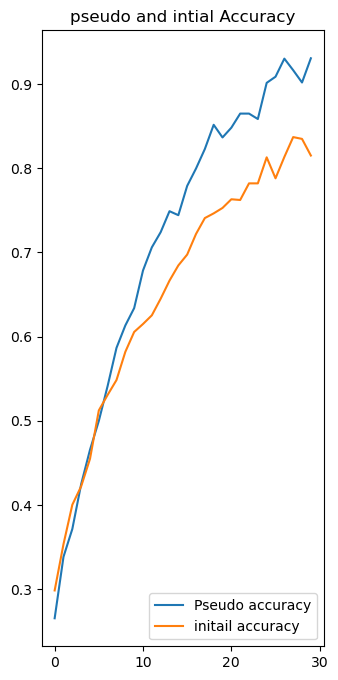

In [21]:
epochs_range=range(30)
plt.figure(figsize=(8, 8))
# Creates a new figure for the plot with a size of 8x8 inches.
plt.subplot(1, 2, 1)
# Creates a subplot within the figure: 1 row, 2 columns, and this plot is the first one.
plt.plot(epochs_range, acc, label='Pseudo accuracy')
plt.plot(epochs_range, intial_acc, label='initail accuracy')
plt.legend(loc='lower right')
plt.title('pseudo and intial Accuracy')



Text(0.5, 1.0, 'pseudo and initial validation accuracy')

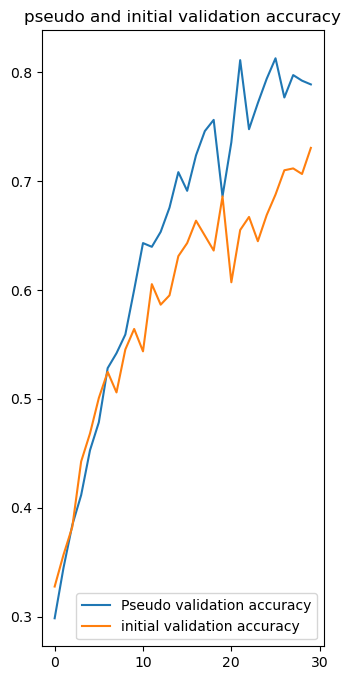

In [22]:
epochs_range=range(30)
plt.figure(figsize=(8, 8))
# Creates a new figure for the plot with a size of 8x8 inches.
plt.subplot(1, 2, 1)
# Creates a subplot within the figure: 1 row, 2 columns, and this plot is the first one.
plt.plot(epochs_range, val_acc, label='Pseudo validation accuracy')
plt.plot(epochs_range, intial_val_acc, label='initial validation accuracy')
plt.legend(loc='lower right')
plt.title('pseudo and initial validation accuracy')



Text(0.5, 1.0, 'pseudo and initail loss')

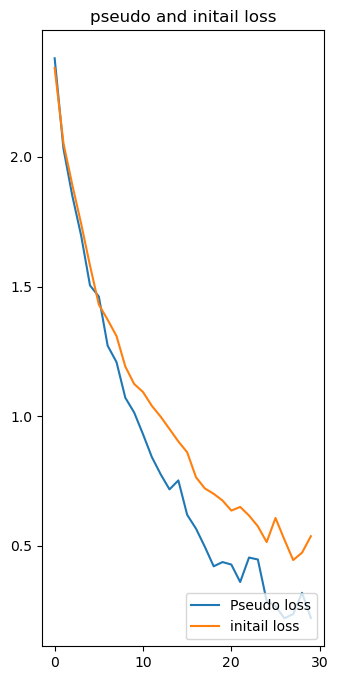

In [23]:
epochs_range=range(30)
plt.figure(figsize=(8, 8))
# Creates a new figure for the plot with a size of 8x8 inches.
plt.subplot(1, 2, 1)
# Creates a subplot within the figure: 1 row, 2 columns, and this plot is the first one.
plt.plot(epochs_range, loss, label='Pseudo loss')
plt.plot(epochs_range, intial_loss, label='initail loss')
plt.legend(loc='lower right')
plt.title('pseudo and initail loss')



In [1]:
epochs_range=range(30)
plt.figure(figsize=(8, 8))
# Creates a new figure for the plot with a size of 8x8 inches.
plt.subplot(1, 2, 1)
# Creates a subplot within the figure: 1 row, 2 columns, and this plot is the first one.
plt.plot(epochs_range, val_loss, label='Pseudo validation loss')
plt.plot(epochs_range, intial_val_loss, label='initial validation loss')
plt.legend(loc='lower right')
plt.title('pseudo and initial validation loss')



NameError: name 'plt' is not defined

In [ ]:
import tensorflow as tf
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available")
else:
    print("GPU is not available")


# For increasing the accuracy of step-4,we can try out following things:
1.modifying the achitecture
2.hyper parameter tuning the training parameters like batch_size,optimizer and learining rate